<a href="https://colab.research.google.com/github/8hehe8/20201101/blob/main/CA2_20201101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import gensim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.nn.functional as F
from natsort import natsorted
from torch import nn, optim
from torch.autograd import Variable
from torchtext import datasets, vocab
from torchtext.legacy import data
from collections import Counter
from torch.nn.utils.rnn import pack_padded_sequence

In [2]:
cd drive/MyDrive/AI_class/amazon_review/

/content/drive/MyDrive/AI_class/amazon_review


## Loading txt and cover to csv

In [3]:
# read txt file
def load_train_txt():
    data, labels = [], []
    
    for label in ('positive', 'negative'):
        folder_name = os.path.join('train', label)

        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n','')
                data.append(review)
                labels.append(1 if label == 'positive' else 0)

    return data, labels

def load_test_txt():
    filename, data = [], []

    folder_name = os.path.join('test')

    for file in os.listdir(folder_name):
        with open(os.path.join(folder_name, file), 'rb') as f:
            review = f.read().decode('utf-8').replace('\n','')
            data.append(review)
            filename.append(file)

    return filename, data

train_data = load_train_txt()
train_data_df = pd.DataFrame(train_data, index=['text','label']).transpose()
train_data_df.to_csv('train_data.csv', sep=',', index=False)

## Generally used codes

In [188]:
def train(model, optimizer, train_loader, loss_function):
    model.train()
    corrects, total_loss = 0, 0

    for batch in train_loader:
        x = batch.text.to(device)
        y = batch.label.to(device)

        optimizer.zero_grad()
        
        pred = model(x)
        # print(pred.shape, y.shape)
        loss = loss_function(pred, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        corrects += (pred.max(1)[1].view(y.size()).data == y.data).sum()

    size = len(train_loader.dataset)
    avg_loss = total_loss / size
    avg_accuracy = corrects / size

    return avg_loss, avg_accuracy

def evaluate(model, val_loader):
    model.eval()

    corrects, total_loss = 0, 0
    for batch in val_loader:
        x, y = batch.text.to(device), batch.label.to(device)
        
        pred = model(x)
        loss = loss_function(pred, y)
        
        total_loss += loss.item()
        corrects += (pred.max(1)[1].view(y.size()).data == y.data).sum()

    size = len(val_loader.dataset)
    avg_loss = total_loss / size
    avg_accuracy = corrects / size

    return avg_loss, avg_accuracy

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])

def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

device = try_gpu()

In [5]:
# define field
TEXT = data.Field(sequential=True,
                  use_vocab=True,
                  tokenize=str.split,
                  lower=True,
                  batch_first=True,
                  fix_length=20)

LABEL = data.Field(sequential=False,
                   use_vocab=False,
                   batch_first=False,
                   is_target=True)

# create dataset
train_dataset = data.TabularDataset(
    path='train_data.csv', format='csv',
    fields=[('text', TEXT), ('label', LABEL)], skip_header=True)

TEXT.build_vocab(train_dataset, max_size=10000, min_freq=10)

In [6]:
# create dataloder
batch_size = 5
train_loader = data.Iterator(train_dataset, batch_size=batch_size)
print('# of training data mini batch : {}'.format(len(train_loader)))

# of training data mini batch : 412


## With pretratined embedding.

### model define

In [234]:
# load embeddings from txt
word2vec = gensim.models.KeyedVectors.load_word2vec_format('all.review.vec.txt')
weights = torch.FloatTensor(word2vec.vectors)
embedding = nn.Embedding.from_pretrained(weights, freeze=False)
embedding.to(device)

Embedding(56050, 100)

In [235]:
class RNN_Net(nn.Module):
    def __init__(self, embed_size, num_hiddens, num_layers, **kwargs):
        super(RNN_Net, self).__init__(**kwargs)
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers, bidirectional=True)
        self.tanh = nn.Tanh()
        self.decoder = nn.Linear(4*num_hiddens, 2)

    def forward(self, embeddings):
        embeddings = embedding(embeddings.T)
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        outputs = self.tanh(outputs)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)

        return outs

class CNN_Net(nn.Module):
    def __init__(self, num_filters, num_channels, **kwargs):
        super(CNN_Net, self).__init__(**kwargs)

        self.conv = nn.Conv1d(in_channels=100, 
                              out_channels=num_filters,
                              kernel_size=3)

        self.relu = nn.ReLU()
        self.fc = nn.Linear(num_filters, 2) # 300, 2
    
    def forward(self, inputs):
        embedded = embedding(inputs)
        embedded = embedded.permute(0, 2, 1)
        conved = self.conv(embedded)
        conved = self.relu(conved)
        pooled = F.max_pool1d(conved, conved.shape[2]).squeeze(2)
        cat = torch.cat([pooled], dim=1)
        outputs = self.fc(cat) 

        return outputs

### training

In [236]:
# for CNN model
num_filters, num_channels = 100, 3

model_CNN = CNN_Net(num_filters=num_filters, num_channels=num_channels)
optimizer = optim.Adam(params=model_CNN.parameters())

model_CNN.apply(init_weights)
model_CNN.to(device)

loss_function = nn.CrossEntropyLoss()
loss_function.to(device)

num_epochs = 8

for epoch in range(num_epochs):
    train_loss, train_acc = train(model_CNN, optimizer, train_loader, loss_function)
    print(f'\tTrain Loss: {train_loss} | Train Acc: {train_acc}%')

	Train Loss: 0.13708613986529192 | Train Acc: 0.5514563322067261%
	Train Loss: 0.11889809297705159 | Train Acc: 0.7072815895080566%
	Train Loss: 0.09679602362143183 | Train Acc: 0.7898058295249939%
	Train Loss: 0.07379620495134766 | Train Acc: 0.8553398251533508%
	Train Loss: 0.04844394911858208 | Train Acc: 0.9432039260864258%
	Train Loss: 0.03180334815321472 | Train Acc: 0.9771844744682312%
	Train Loss: 0.0191230863988291 | Train Acc: 0.9917476177215576%
	Train Loss: 0.01183411914819074 | Train Acc: 0.9980582594871521%


In [237]:
## For RNN model
embed_size, num_hiddens, num_layers = weights.shape[1], 100, 2
# 100, 100, 2

model_RNN = RNN_Net(embed_size, num_hiddens, num_layers)
optimizer = optim.Adam(params=model_RNN.parameters())

model_RNN.apply(init_weights)
model_RNN.to(device)

loss_function = nn.CrossEntropyLoss()
loss_function.to(device)

num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train(model_RNN, optimizer, train_loader, loss_function)
    print(f'\tTrain Loss: {train_loss} | Train Acc: {train_acc}%')

	Train Loss: 0.134552758671705 | Train Acc: 0.5796116590499878%
	Train Loss: 0.12056100338842105 | Train Acc: 0.6582524180412292%
	Train Loss: 0.11145429203232515 | Train Acc: 0.6985437273979187%
	Train Loss: 0.10321670796686006 | Train Acc: 0.7359223365783691%
	Train Loss: 0.09066796680387941 | Train Acc: 0.7786408066749573%
	Train Loss: 0.07481819697411604 | Train Acc: 0.825728178024292%
	Train Loss: 0.05829385371688862 | Train Acc: 0.8713592290878296%
	Train Loss: 0.040374979790688936 | Train Acc: 0.9189320802688599%
	Train Loss: 0.026515397533759682 | Train Acc: 0.9446601867675781%
	Train Loss: 0.01788088760717497 | Train Acc: 0.9640777111053467%


## Without pretrained embedding

### data processing

In [238]:
word_set = []
for w in train_data_df['text']:
    temp = set(w.split())
    word_set.append(list(temp))

word_set = sum(word_set, [])

vocab = {word: i+2 for i, word in enumerate(word_set)}
vocab['<unk>'] = 0
vocab['<pad>'] = 1

vocab_size = len(vocab)

### model define

In [239]:
embedding_wo = nn.Embedding(num_embeddings=vocab_size, embedding_dim=100)
embedding_wo.to(device)

Embedding(24475, 100)

In [240]:
class RNN_Net_wo(nn.Module):
    def __init__(self, embed_size, num_hiddens, num_layers, **kwargs):
        super(RNN_Net_wo, self).__init__(**kwargs)
        
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers, bidirectional=True)
        self.tanh = nn.Tanh()
        self.decoder = nn.Linear(4*num_hiddens, 2)

    def forward(self, embedded):
        embedded = embedding_wo(embedded.T)
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embedded)
        outputs = self.tanh(outputs)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)

        return outs


class CNN_Net_wo(nn.Module):
    def __init__(self, num_filters, num_channels, **kwargs):
        super(CNN_Net_wo, self).__init__(**kwargs)

        self.conv = nn.Conv1d(in_channels=100, 
                              out_channels=num_filters,
                              kernel_size=3)

        self.relu = nn.ReLU()
        self.fc = nn.Linear(num_filters, 2)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, inputs):
        # print(inputs.shape)
        #batch size, sent len 5,20
        embedded = embedding_wo(inputs)
        embedded = embedded.permute(0, 2, 1)
        # print(embedded.shape)
        # batch size, embed_size, sent len

        conved = self.conv(embedded)
        conved = self.relu(conved)
        # print(conved.shape)
        # batch size, num_filters, 18

        pooled = F.max_pool1d(conved, conved.shape[2]).squeeze(2)
        # print(pooled.shape)
        #batch size, num_filters

        cat = torch.cat([pooled], dim=1)
        # cat = self.dropout(torch.cat([pooled], dim=1))
        outputs = self.fc(cat) 

        return outputs

### training

In [241]:
# for CNN model
num_filters, num_channels = 100, 3

model_CNN_wo = CNN_Net_wo(num_filters=num_filters, num_channels=num_channels)
optimizer = optim.Adam(params=model_CNN_wo.parameters())

model_CNN_wo.apply(init_weights)
model_CNN_wo.to(device)

loss_function = nn.CrossEntropyLoss()
loss_function.to(device)

num_epochs = 4

for epoch in range(num_epochs):
    train_loss, train_acc = train(model_CNN_wo, optimizer, train_loader, loss_function)
    print(f'\tTrain Loss: {train_loss} | Train Acc: {train_acc}%')

	Train Loss: 0.13284513040364368 | Train Acc: 0.635922372341156%
	Train Loss: 0.0749703146191766 | Train Acc: 0.8456310629844666%
	Train Loss: 0.04053307911290706 | Train Acc: 0.9475728273391724%
	Train Loss: 0.019058046313635644 | Train Acc: 0.9868932366371155%


In [242]:
## For RNN model
embed_size, num_hiddens, num_layers = 100, 100, 2
# 100, 100, 2

model_RNN_wo = RNN_Net_wo(embed_size, num_hiddens, num_layers)
optimizer = optim.Adam(params=model_RNN_wo.parameters())

model_RNN_wo.apply(init_weights)
model_RNN_wo.to(device)

loss_function = nn.CrossEntropyLoss()
loss_function.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    train_loss, train_acc = train(model_RNN_wo, optimizer, train_loader, loss_function)
    print(f'\tTrain Loss: {train_loss} | Train Acc: {train_acc}%')

	Train Loss: 0.12507658245638736 | Train Acc: 0.648058295249939%
	Train Loss: 0.09888111637199967 | Train Acc: 0.7480582594871521%
	Train Loss: 0.06506503335815104 | Train Acc: 0.8553398251533508%
	Train Loss: 0.026069051393144426 | Train Acc: 0.9500000476837158%
	Train Loss: 0.009408648020689725 | Train Acc: 0.984466016292572%


## Report 1

In [16]:
wordDict = Counter()
text_length = []
def count():
    for label in ('positive', 'negative'):
        folder_name = os.path.join('train', label)

        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                sentences = f.readlines()
                text_length.append(len(str(sentences)))
                for sentence in sentences:
                    for word in sentence.split():
                        wordDict[word] += 1
        
        folder_name = 'test'
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                sentences = f.readlines()
                text_length.append(len(str(sentences)))
                for sentence in sentences:
                    for word in sentence.split():
                        wordDict[word] += 1

count()
word_list = []
for word in wordDict:
    if word in word_list:
        pass
    else:
        word_list.append(word)


## TEST Dataset

### data processing

In [17]:
test_data = load_test_txt()
test_data_df = pd.DataFrame(test_data, index=['filename','text']).transpose()
test_data_index = test_data_df.set_index(keys=['filename'], drop=True)
test_data_index = test_data_index.reindex(index=natsorted(test_data_index.index))

filename_index = test_data_index.index

texts = test_data_index['text']
texts.to_csv('test_data.csv', sep=',', index=False)

In [18]:
# define field
TEXT_eval = data.Field(sequential=True,
                  use_vocab=True,
                  tokenize=str.split,
                  lower=True,
                  batch_first=True,
                  fix_length=20)

# create dataset
test_dataset = data.TabularDataset(
    path='test_data.csv', format='csv',
    fields=[('text', TEXT_eval)], skip_header=True)

test_loader = data.Iterator(test_dataset, batch_size=batch_size)
TEXT_eval.build_vocab(test_dataset, max_size=10000, min_freq=10)

### training

In [19]:
def test_eval(model, test_loader):
    model.eval()
    test_pred = []
    start = time.time()
    for b, batch in enumerate(test_loader):
            x = batch.text.to(device)
            # print(x)
            pred = model(x)
            # print(pred)
            test_pred.append(list((pred.max(1)[1]).cpu().numpy()))

    test_pred = np.concatenate(test_pred).tolist()
    test_pred = pd.Series(test_pred)

    end = time.time()
    return test_pred, end-start

test_pred_RNN, time_RNN = test_eval(model_RNN, test_loader)
test_pred_CNN, time_CNN = test_eval(model_CNN, test_loader)
test_pred_CNN_wo, time_CNN_wo = test_eval(model_CNN_wo, test_loader)
test_pred_RNN_wo, time_RNN_wo = test_eval(model_RNN_wo, test_loader)

# filename = test_pred.index
# submit_csv = pd.DataFrame([filename, test_pred]).transpose()

In [20]:
time_RNN, time_CNN, time_CNN_wo, time_RNN_wo

(0.6972141265869141,
 0.23620080947875977,
 0.23070716857910156,
 0.6709699630737305)

In [21]:
RNN_csv = pd.DataFrame([filename_index, test_pred_RNN], index=['id','sentiment']).transpose()
CNN_csv = pd.DataFrame([filename_index, test_pred_CNN], index=['id','sentiment']).transpose()
RNN_wo_csv = pd.DataFrame([filename_index, test_pred_RNN_wo], index=['id','sentiment']).transpose()
CNN_wo_csv = pd.DataFrame([filename_index, test_pred_CNN_wo], index=['id','sentiment']).transpose()

In [22]:
RNN_csv.to_csv('predictions/test_RNN.csv', sep=',', index=False)
CNN_csv.to_csv('predictions/test_CNN.csv', sep=',', index=False)
RNN_wo_csv.to_csv('predictions/test_RNN_wo.csv', sep=',', index=False)
CNN_wo_csv.to_csv('predictions/test_CNN_wo.csv', sep=',', index=False)

## validation set

In [243]:
# making val_set
train_set, val_set = train_dataset.split(split_ratio=0.7)

In [244]:
# create dataloder
batch_size = 8
train_loader2 = data.Iterator(train_set, batch_size=batch_size, shuffle=True)
val_loader2 = data.Iterator(val_set, batch_size=batch_size, shuffle=False)
print('# of training data mini batch : {}'.format(len(train_loader2)))

# of training data mini batch : 181


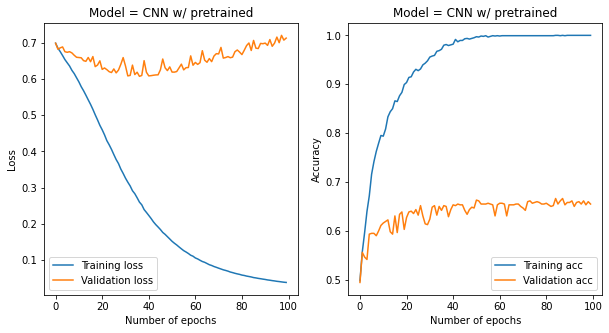

In [245]:
num_filters, num_channels = 100, 3

model_CNN = CNN_Net(num_filters=num_filters, num_channels=num_channels)
optimizer = optim.SGD(params=model_CNN.parameters(), lr=0.001)

model_CNN.apply(init_weights)
model_CNN.to(device)

loss_function = nn.CrossEntropyLoss(reduction='sum')
loss_function.to(device)

num_epochs = 100

bset_val_loss = None

loss1, acc1 = [], []
loss2, acc2 = [], []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_CNN, optimizer, train_loader2, loss_function)
    val_loss, val_acc = evaluate(model_CNN, val_loader2)

    loss1.append(train_loss)
    acc1.append(train_acc)
    loss2.append(val_loss)
    acc2.append(val_acc)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Model = CNN w/ pretrained')
plt.plot(range(num_epochs), loss1, range(num_epochs), loss2)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])

plt.subplot(1,2,2)
plt.title('Model = CNN w/ pretrained')
plt.plot(range(num_epochs), acc1, range(num_epochs), acc2)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend(['Training acc', 'Validation acc'])

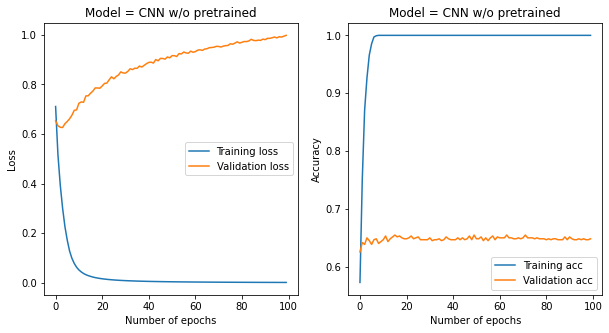

In [246]:
num_filters, num_channels = 100, 3

model_CNN_wo = CNN_Net_wo(num_filters=num_filters, num_channels=num_channels)
optimizer = optim.SGD(params=model_CNN_wo.parameters(), lr=0.001)

model_CNN_wo.apply(init_weights)
model_CNN_wo.to(device)

loss_function = nn.CrossEntropyLoss(reduction='sum')
loss_function.to(device)

num_epochs = 100

bset_val_loss = None

loss1, acc1 = [], []
loss2, acc2 = [], []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_CNN_wo, optimizer, train_loader2, loss_function)
    val_loss, val_acc = evaluate(model_CNN_wo, val_loader2)

    loss1.append(train_loss)
    acc1.append(train_acc)
    loss2.append(val_loss)
    acc2.append(val_acc)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Model = CNN w/o pretrained')
plt.plot(range(num_epochs), loss1, range(num_epochs), loss2)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])

plt.subplot(1,2,2)
plt.title('Model = CNN w/o pretrained')
plt.plot(range(num_epochs), acc1, range(num_epochs), acc2)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend(['Training acc', 'Validation acc'])

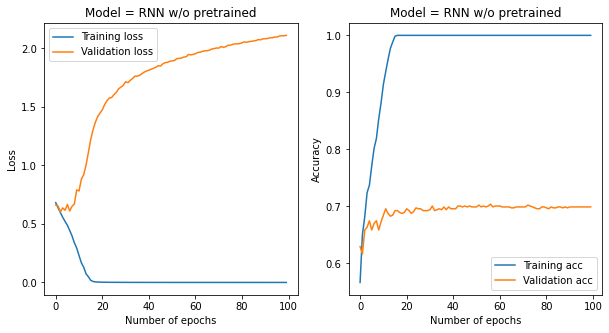

In [247]:
## For RNN model
embed_size, num_hiddens, num_layers = 100, 100, 2
# 100, 100, 2

model_RNN_wo = RNN_Net_wo(embed_size, num_hiddens, num_layers)
optimizer = optim.SGD(params=model_RNN_wo.parameters(), lr=0.01)

model_RNN_wo.apply(init_weights)
model_RNN_wo.to(device)

loss_function = nn.CrossEntropyLoss(reduction='sum')
loss_function.to(device)

num_epochs = 100

loss1, acc1 = [], []
loss2, acc2 = [], []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_RNN_wo, optimizer, train_loader2, loss_function)
    val_loss, val_acc = evaluate(model_RNN_wo, val_loader2)

    loss1.append(train_loss)
    acc1.append(train_acc)
    loss2.append(val_loss)
    acc2.append(val_acc)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Model = RNN w/o pretrained')
plt.plot(range(num_epochs), loss1, range(num_epochs), loss2)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])

plt.subplot(1,2,2)
plt.title('Model = RNN w/o pretrained')
plt.plot(range(num_epochs), acc1, range(num_epochs), acc2)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend(['Training acc', 'Validation acc'])

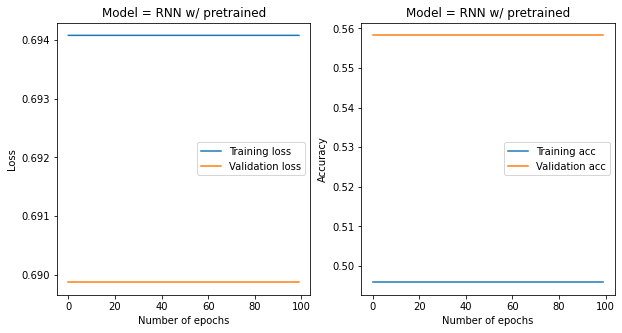

In [248]:
## For RNN model
embed_size, num_hiddens, num_layers = 100, 100, 2
# 100, 100, 2

model_RNN = RNN_Net(embed_size, num_hiddens, num_layers)
optimizer = optim.SGD(params=model_RNN_wo.parameters(), lr=0.1)

model_RNN.apply(init_weights)
model_RNN.to(device)

loss_function = nn.CrossEntropyLoss(reduction='sum')
loss_function.to(device)

num_epochs = 100

loss1, acc1 = [], []
loss2, acc2 = [], []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_RNN, optimizer, train_loader2, loss_function)
    val_loss, val_acc = evaluate(model_RNN, val_loader2)

    loss1.append(train_loss)
    acc1.append(train_acc)
    loss2.append(val_loss)
    acc2.append(val_acc)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Model = RNN w/ pretrained')
plt.plot(range(num_epochs), loss1, range(num_epochs), loss2)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])

plt.subplot(1,2,2)
plt.title('Model = RNN w/ pretrained')
plt.plot(range(num_epochs), acc1, range(num_epochs), acc2)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend(['Training acc', 'Validation acc'])

## New design


In [210]:
class GRU(nn.Module):
    def __init__(self, embeddig, n_layers=1, hidden_dim=100, embed_dim=100, n_classes=2, 
                 dropout_p=0.2):
        super(GRU, self).__init__()
        self.embedding = embedding
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embed_dim, self.hidden_dim,
                          num_layers=self.n_layers,
                          batch_first=True)
        self.activation = nn.ReLU()
        self.out = nn.Linear(self.hidden_dim, n_classes)

    def forward(self, x):
        x = embedding(x)
        h_0 = self._init_state(batch_size=x.size(0)) # 첫번째 히든 스테이트를 0벡터로 초기화
        x, _ = self.gru(x, h_0)  # GRU의 리턴값은 (배치 크기, 시퀀스 길이, 은닉 상태의 크기)
        h_t = x[:,-1,:] # (배치 크기, 은닉 상태의 크기)의 텐서로 크기가 변경됨. 즉, 마지막 time-step의 은닉 상태만 가져온다.
        self.dropout(h_t)
        logit = self.out(self.activation(h_t))  # (배치 크기, 은닉 상태의 크기) -> (배치 크기, 출력층의 크기)
        return logit

    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

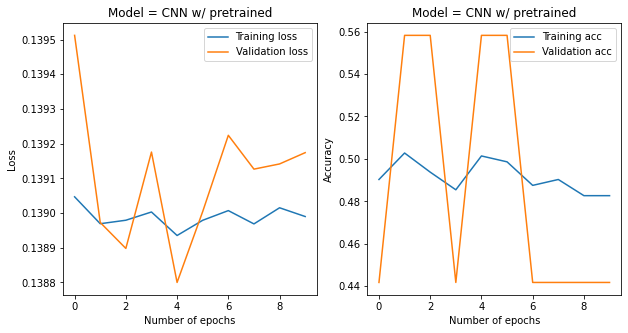

In [231]:
embedding = nn.Embedding.from_pretrained(weights, freeze=False).to(device)

#basic training configuration
num_epochs = 10
batch_size = 5
lr = 1e-2

# create dataloder
train_loader2 = data.Iterator(train_set, batch_size=batch_size, shuffle=True)
val_loader2 = data.Iterator(val_set, batch_size=batch_size, shuffle=False)

model = GRU(embedding).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0.2)

loss_function = nn.CrossEntropyLoss().to(device)

loss1, acc1 = [], []
loss2, acc2 = [], []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, optimizer, train_loader2, loss_function)
    val_loss, val_acc = evaluate(model, val_loader2)
    # print(f'\tTrain Loss: {train_loss} | Train Acc: {train_acc}%')
    # print(f'\tval Loss: {val_loss} | val Acc: {val_acc}%')

    loss1.append(train_loss)
    acc1.append(train_acc)
    loss2.append(val_loss)
    acc2.append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model, 'model_new3')

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Model = CNN w/ pretrained')
plt.plot(range(num_epochs), loss1, range(num_epochs), loss2)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])

plt.subplot(1,2,2)
plt.title('Model = CNN w/ pretrained')
plt.plot(range(num_epochs), acc1, range(num_epochs), acc2)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend(['Training acc', 'Validation acc'])

In [201]:
test_pred_new, time_new = test_eval(model, test_loader)
new_csv = pd.DataFrame([filename_index, test_pred_new], index=['id','sentiment']).transpose()
new_csv.to_csv('predictions/test_new4.csv', sep=',', index=False)